# Basic Tutorial

> The main abstractions in `emb_opt` and how to use them

## Overview

The goal of `emb_opt` is to use hill climbing to find high scoring items (defined by some score function) in a vector database without exhaustive screening of the database itself.

`emb_opt` takes advantage of the inherent structure present in embedding spaces. Starting with random points, we can use reinforcement learning to traverse the vector space to move from low scoring items to high scoring items.

This notebook gives an overview of the main abstractions in `emb_opt` and how they fit together.

In [ ]:
from emb_opt.imports import *
from emb_opt.schemas import Query, Item, Batch

In [ ]:
import string
from datasets import Dataset

/home/dmai/miniconda3/envs/emb_opt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
n_vectors = 10000
size = 64

vectors = np.random.randn(n_vectors, size)

vector_data = [{
                'index' : i,
                'item' : ''.join(np.random.choice([i for i in string.ascii_lowercase], size=10).tolist()),
                'rand' : np.random.rand(),
                'embedding' : vectors[i]
            } for i in range(n_vectors)]

vector_dataset = Dataset.from_list(vector_data)
vector_dataset.add_faiss_index('embedding')

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1102.63it/s]


Dataset({
    features: ['index', 'item', 'rand', 'embedding'],
    num_rows: 10000
})

In [ ]:
from emb_opt.plugins.huggingface import HugggingfaceDataPlugin

In [ ]:
k = 10

data_plugin = HugggingfaceDataPlugin(k=k, dataset=vector_dataset, 
                                    index_name='embedding', item_key='item', 
                                     id_key='index', distance_cutoff=None)

In [ ]:
from emb_opt.schemas import FilterResponse

In [ ]:
def rand_filter(inputs):
    return [FilterResponse(valid=i.data['rand']<0.9, data={'rand':i.data['rand']}) for i in inputs]

In [ ]:
from emb_opt.schemas import ScoreResponse

In [ ]:
def score_embeddings(embeddings, seed=29):
    np.random.seed(seed)
#     target_point = np.random.randn(size)/2
    target_point = np.ones(size)
    
#     scores = np.exp(-np.linalg.norm(embeddings - target_point, axis=1))
    scores = np.exp(-((embeddings - target_point)**2).sum(-1)**0.5)
    return scores

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def pca(x, k=2):
    x = x - x.mean(0)
    u,s,v = np.linalg.svd(x.transpose(), full_matrices=False)
    return x @ u[:, :k]

In [ ]:
scores = score_embeddings(vectors)

<matplotlib.collections.PathCollection>

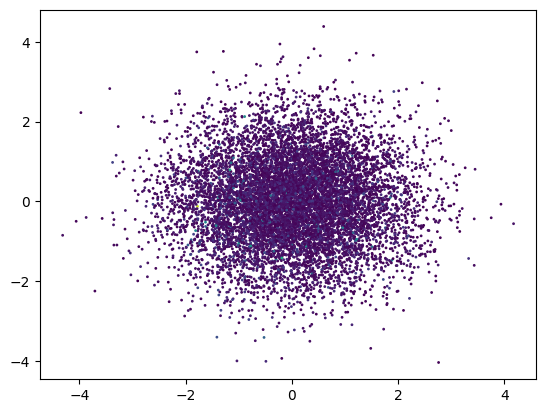

In [ ]:
vectors_reduced = pca(vectors)
plt.scatter(vectors_reduced[:,0], vectors_reduced[:,1], s=1, c=scores)
# plt.scatter(vectors[:,0], vectors[:,1], s=1, c=scores)

In [ ]:
scores.mean()

1.8000672986413203e-05

In [ ]:
scores.max()

0.00032587741085156747

In [ ]:
scores.max()/scores.mean()

18.103623742153292

In [ ]:
def score_function(inputs):    
    embeddings = np.array([i.embedding for i in inputs])
    scores = score_embeddings(embeddings)    
    results = [ScoreResponse(valid=True, score=i, data=None) for i in scores]
    return results

In [ ]:
from emb_opt.update import RLUpdate

In [ ]:
distance_penalty = 0.05
lrs = np.array([0.5, 1, 5, 10])/10
update_function = RLUpdate(lrs, distance_penalty, max_norm=1.)

In [ ]:
from emb_opt.prune import TopKPruneLocal, TopKGlobalPrune

In [ ]:
# prune_func = None
prune_func = TopKPruneLocal(1)
# prune_func = TopKGlobalPrune(10)

In [ ]:
from emb_opt.runner import Runner

In [ ]:
runner = Runner(data_plugin, rand_filter, score_function, prune_func, update_function)

In [ ]:
from emb_opt.utils import build_batch_from_embeddings

In [ ]:
n_queries = 10
n_iters = 10
initial_queries = np.random.randn(n_queries, size)

input_batch = build_batch_from_embeddings(initial_queries)

In [ ]:
output_batch, search_log = runner.search(input_batch, 10)

0 0.28 0.38 0.36 0.36 0.72 0.19 0.21 0.34 0.26 0.21
1 0.29 0.42 0.44 0.46 0.76 0.23 0.25 0.48 0.35 0.27
2 0.34 0.42 0.54 0.46 0.76 0.33 0.29 0.55 0.38 0.29
3 0.34 0.41 0.59 0.46 0.73 0.37 0.31 0.55 0.37 0.34
4 0.34 0.41 0.59 0.46 0.76 0.37 0.31 0.51 0.37 0.40
5 0.34 0.48 0.59 0.46 0.75 0.37 0.31 0.54 0.38 0.41
6 0.34 0.50 0.59 0.52 0.74 0.40 0.31 0.54 0.43 0.42
7 0.38 0.52 0.56 0.55 0.76 0.40 0.31 0.54 0.43 0.41
8 0.39 0.60 0.59 0.58 0.74 0.40 0.31 0.54 0.43 0.39
9 0.39 0.60 0.54 0.58 0.76 0.38 0.30 0.54 0.43 0.40


In [ ]:
output_batch, search_log = runner.search(output_batch, 10, log=search_log)

10 0.39 0.60 0.56 0.58 0.74 0.40 0.36 0.54 0.44 0.41
11 0.39 0.57 0.52 0.58 0.75 0.40 0.39 0.55 0.43 0.39
12 0.46 0.58 0.57 0.54 0.76 0.40 0.45 0.53 0.44 0.41
13 0.46 0.57 0.63 0.58 0.76 0.38 0.46 0.53 0.44 0.44
14 0.45 0.56 0.59 0.54 0.75 0.39 0.49 0.52 0.43 0.47
15 0.53 0.62 0.58 0.54 0.75 0.38 0.49 0.53 0.43 0.49
16 0.54 0.62 0.57 0.55 0.74 0.38 0.52 0.53 0.52 0.49
17 0.55 0.58 0.55 0.58 0.77 0.42 0.52 0.52 0.54 0.48
18 0.59 0.61 0.55 0.57 0.74 0.42 0.54 0.52 0.59 0.48
19 0.55 0.61 0.54 0.57 0.77 0.42 0.56 0.51 0.67 0.50


In [ ]:
results = search_log.compile_results(skip_removed=True)

In [ ]:
len(results)

222

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from emb_opt.log import QueryTree

In [ ]:
tree = QueryTree()
tree.build_tree(search_log)

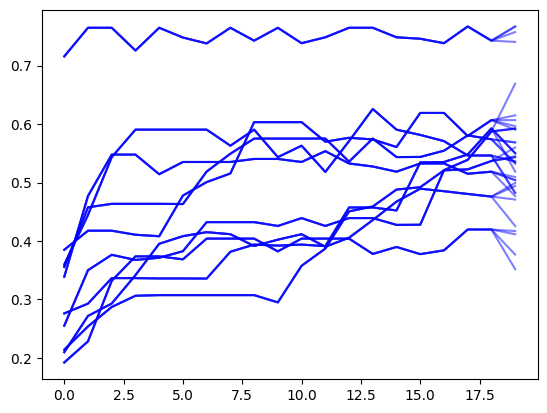

In [ ]:
for final_node in tree.final_nodes:
    max_scores = []
    
    current = final_node
    while current:
        max_scores.append(current.mean_score)
        current = current.parent
        
    plt.plot(max_scores[::-1], color='b', alpha=0.5)

In [ ]:
ground_truth = vector_dataset.map(lambda row: {'score' : float(score_embeddings(np.array(row['embedding'])[None]))})
ground_truth.filter(lambda row: row['rand']<0.9)
ground_truth = ground_truth.sort('score', reverse=True)

In [ ]:
k_vals = [1, 5, 10, 50]
recovered_ids = set([i['id'] for i in results])
metrics = []

for k in k_vals:
    gt_idxs = set(ground_truth[:k]['index'])
    percent_recovered = len(gt_idxs.intersection(recovered_ids))/k
    metrics.append(percent_recovered)
    
metrics

[0.0, 0.2, 0.1, 0.26]

In [ ]:
trajectories = []

for final_node in tree.final_nodes:
    
    if not final_node.query.internal.removed:
        node_trajectory = []
        current = final_node
        while current:
            node_trajectory.append(current)
            current = current.parent

        node_trajectory = node_trajectory[::-1]
        trajectories.append(node_trajectory)

In [ ]:
query_traj = [np.array([i.query.embedding for i in j]) for j in trajectories]

In [ ]:
vecs = []
labels = []
for i, block in enumerate([vectors]+query_traj):
    vecs.append(block)
    labels.append([i for _ in range(block.shape[0])])

In [ ]:
all_vecs = np.concatenate(vecs)

In [ ]:
def pca(x, k=2):
    x = x - x.mean(0)
    u,s,v = np.linalg.svd(all_vecs.transpose(), full_matrices=False)
    return x @ u[:, :k]

In [ ]:
all_vecs_reduced = pca(all_vecs)

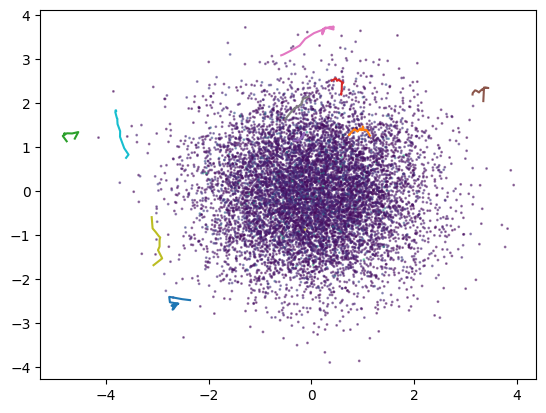

In [ ]:
start = 0
for i in range(len(labels)):
    end = start + len(labels[i])
    block = all_vecs_reduced[start:end]
    
    if i == 0:
        plt.scatter(block[:,0], block[:,1], s=1, alpha=0.5, c=score_embeddings(vectors))
    else:
        plt.plot(block[:,0], block[:,1])
        
    start = end

In [ ]:
[i['score'] for i in results[:10]]

[29.88436049635304,
 29.00741228633503,
 27.725509144193385,
 27.235482165287326,
 27.024579464981237,
 26.949750838818204,
 26.865423440238377,
 26.67855098580714,
 26.417027245168825,
 26.284619335040286]

In [ ]:
ground_truth[:10]['score']

[32.71752967128846,
 32.59540464653555,
 31.564421837531025,
 30.301493558661406,
 29.88436049635304,
 29.060906571794717,
 29.007412286335022,
 28.302677981521605,
 28.204978273412863,
 28.04333721049486]

In [ ]:
from emb_opt.imports import *
from emb_opt.core import Filter, Score
from emb_opt.backends.hf import HFDatabase
from emb_opt.query_update import RLUpdate
from emb_opt.runner import Runner
import matplotlib.pyplot as plt

/home/dmai/miniconda3/envs/emb_opt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

First we need a vector database to query. Since this is just an example notebook, we will work off a set of random vectors.

We will use the [Datasets](https://huggingface.co/docs/datasets/index) library to hold our vectors and build our index.

In addition to the embedding vector, we will also add a `rand` column of random values. This will be used later to demonstrate the `Filter` functionality.

In [ ]:
n_vectors = 10000
size = 128

vectors = np.random.randn(n_vectors, size)
vector_dataset = Dataset.from_list([{'embedding':i, 'rand':np.random.rand()} for i in vectors])
vector_dataset.add_faiss_index('embedding')

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 908.13it/s]


Dataset({
    features: ['embedding', 'rand'],
    num_rows: 10000
})

## Database Backend

`emb_opt` has a standardized way of returning results from a vector database query. Since we are using a Huggingface Dataset for our index, we will use the corresponding `HFDatabase` backend.

`emb_opt` currently supports [faiss](https://github.com/facebookresearch/faiss), [Qdrant](https://qdrant.tech/), [Chroma](https://www.trychroma.com/), and [Huggingface Datasets](https://huggingface.co/docs/datasets/index) as backends.

We will pass `k=10` to return 10 items per query

In [ ]:
k = 10
index_name = 'embedding'
hf_db = HFDatabase(vector_dataset, index_name, k)

### Query API

Queries are sent as a numpy array of vectors. Query results are returned as a `Dataset` with the following columns:

* `query_idx` - the index of the specific query vector that returned a particular row
* `db_idx` - the database index of the item returned
* `embedding` - the embedding of the item returned
* `distance` - distance between the `embedding` and the query vector defined by `query_idx`
* `data` - a dictionary of any other information returned with the query

In [ ]:
example_query = np.random.randn(3, size)
query_results = hf_db.query(example_query)
query_results

Dataset({
    features: ['query_idx', 'db_idx', 'embedding', 'distance', 'data'],
    num_rows: 30
})

Note that the `rand` column we created earlier ends up in the `data` column of the query results

In [ ]:
query_results['data'][0]

{'rand': 0.18091041183937884}

## Score Function

This is the score function we want to maximize. Any function that takes in a row from the `query_results` dataset and returns a single numeric value where "larger = better" can be used.

For a simple example, we will use the sum of our embedding vector as the score

In [ ]:
def simple_score(row):
    return sum(row['embedding'])

map_kwargs = {}
score_function = Score(simple_score, map_kwargs)

### Score Kwargs

In the example above, we passed `map_kwargs = {}` to the score function. Behind the scenes, the score is actually computed using `Dataset.map`

`query_dataset.map(lambda item: {'score' : score_func(item)}, **map_kwargs)`

This allows us to do this like:

```python
# multiprocessing
map_kwargs = {'num_proc' : 5}
score_function = Score(simple_score, map_kwargs)
```

```python
# batched compute
map_kwargs = {'batched' : True}
score_function = Score(simple_score, map_kwargs)
```

Check the [Huggingface Map Documentation](https://huggingface.co/docs/datasets/process#map) for a full set of applicable kwargs.

## Filter Function

For some applications we may wish to filter query results before scoring. 

Some database backends allow for various types of filtering - see `FaissDatabase`, `QdrantDatabase` and `ChromaDatabase` for backend-specific examples.

However, we may wish to filter on things that are not "built in" to our backend, such as the results from a classification model or a metric that is more efficient to compute on the fly rather than pre-computing for the entire database.

The `Filter` class offers this functionality. We can filter query results on any function that returns a boolean value for each row in the `query_results` dataset.

For a simple example, we will use the `rand` column we created earlier and filter any example where `rand>=0.9`.

Note the format of the filter function. The `rand` column (and any other information returned with our query) will be in a dictionary stored in the `data` column of the `query_results` dataset.

In [ ]:
def simple_filter(row):
    return row['data']['rand'] < 0.9

filter_kwargs = {}
filter_function = Filter(simple_filter, filter_kwargs)

### Filter Kwargs

Similar to the score function, filtering is implemented via `Dataset.filter`. You can pass any kwargs for `Dataset.filter` to `Filter`. 

`query_dataset.filter(lambda item: filter_func(item), **filter_kwargs)`

See the [Huggingface Filter documentation](https://huggingface.co/docs/datasets/process#select-and-filter)

## Query Update

A `QueryUpdate` takes a set of `query_vectors`, a dataset of `query_results` and uses them to generate the next iteration of `query_vectors`

We will use the `RLUpdate` class to use reinforcement learning to iteratively move `query_vectors` from low scoring locations to high scoring locations

In [ ]:
query_update = RLUpdate(lr=5.)

## Runner

The `Runner` collects the pieces we have created so far and runs the actual optimization process.

The core optimization loop:

```python
for i in range(iterations):
    query_results = self.vector_db.query(query_vectors) # get results
    query_results = self.filter(query_results) # filter results
    query_results = self.score(query_results) # score results

    log.add_entry(i, query_vectors, query_results) # log results

    query_vectors = self.query_update(query_vectors, query_results) # update query vectors

return log
```

In [ ]:
# note that using a Filter is optional
runner = Runner(hf_db, score_function, query_update, filter_function)

## Execute Search

Now we run the search.

To start, we need to get some initial query vectors and decide how many iterations to run. We will use 10 query vectors and run for 10 iterations

In [ ]:
n_queries = 10
n_iters = 10
query_vectors = np.random.rand(n_queries, size)

In [ ]:
log = runner.search(query_vectors, n_iters)

## Results Log

`Runner.search` returns a `SearchLog` which holds the `query_vectors` and `query_results` for each iteration

In [ ]:
iteration = 5
query_vectors = log.batch_log[iteration]['queries']
iteration_results = log.batch_log[iteration]['results']

## Compiled Results

Generally what we want is the scored items returned from the dataset. The `compile_results` function returns this as a `Dataset`

In [ ]:
results = log.compile_results()
results = results.sort('score', reverse=True)
results

Dataset({
    features: ['db_idx', 'embedding', 'data', 'score'],
    num_rows: 227
})

### Notes on results

As seen above, the compiled results contains 227 items. We used 10 query vectors, returned 10 items per query, and ran for 10 iterations. Which would imply 1000 total queries. The reduction from 1000 to 227 is the result of query vectors converging to the same location and returning duplicate values.

The degree of duplicate results depends on:
* size of the vector database
* how query vectors are initialized
* how many local optima exist for your score function
* how many iterations are run
* how many results are returned per query

## Trajectories

We can also grab "trajectories" which show the evolution of a query vector over time. `log.compile_trajectories` returns a dictionary of the form:

```python
{
    'query_idx' : {
        'query_vectors' : (iterations, vector_size) array,
        'scores' : [list of scores at each iteration]
    }
}
```

In [ ]:
trajectories = log.compile_trajectories()

In [ ]:
query_path = trajectories[0]['query_vectors']
score_path = trajectories[0]['scores']

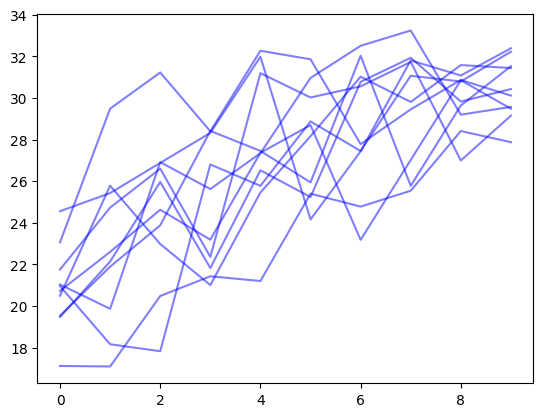

In [ ]:
for k,v in trajectories.items():
    all_scores = v['scores']
    
    plt.plot([np.array(i).mean() for i in all_scores], color='b', alpha=0.5)

## Results Evaluation

Starting from random inputs, we screened 227 items in the database during our search. 

To evaluate the screen, we will look at what percent of the top `K` scoring items were found for various values of `K`.

In [ ]:
# generate ground truth with filtering
ground_truth = vector_dataset.map(lambda row, idx: {'score' : simple_score(row), 'db_idx':idx}, with_indices=True)
ground_truth = ground_truth.filter(lambda row: row['rand']<0.9)
ground_truth = ground_truth.sort('score', reverse=True)

In [ ]:
k_vals = [1, 5, 10, 50]
recovered_set = set(results['db_idx'])
metrics = []

for k in k_vals:
    gt_set = set(ground_truth['db_idx'][:k])
    metrics.append(len(gt_set.intersection(recovered_set)) / len(gt_set))

In [ ]:
metrics

[1.0, 0.6, 0.7, 0.5]

This tells us that we successfully recovered 50% of the top 50 scoring items in the dataset starting with random vector queries and screening 2.27% of the total dataset